In [41]:
import ROOT
import numpy as np
#from root_numpy import random_sample
from scipy.ndimage import uniform_filter
import time
import matplotlib.pyplot as plt
import multiprocessing as mp

<h1>Simulation Model</h1>


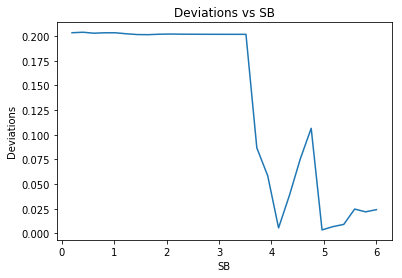

Simulation took 343.3 seconds


/usr/lib64/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [72]:
# the constants of the constants. Pretty much choose once and leave it. Do not change.
C_total_channels = int(3.6 * 1e6)
C_channels_per_module = int(15*30)
C_total_modules = int(C_total_channels/C_channels_per_module)

# skip
#C_max_radius = 1

### Skipping radius dependency for now...

### Distrubution functions:

   # none written...


    
### Code for the simulation:

def get_number_above_threshold(threshold, count, list_):
    """Counts the number of elements above the threshold in the list"""
    arr = np.fromiter(list_, dtype=np.float, count=count)
    above_count = (arr > threshold).sum()
    return above_count

def sample_random_signals(prng, signal_mu, signal_sigma, signal_count):
    """Samples randomly from the Landau distrubution"""
    return [ prng.Landau(signal_mu, signal_sigma) for _ in range(signal_count) ]

def sample_random_noise(prng, noise_sigma, noise_count):
    """Samples randomly from the Gaus distrubution"""
    return [ prng.Gaus(0, noise_sigma) for _ in range(noise_count) ]

def get_number_of_readouts(ratio_of_channels_to_sample):
    """Returns the number of channels to read from - used to downscale simulation"""
    return int(C_total_channels * ratio_of_channels_to_sample)

def simulation_get_counts(prng, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Runs a simulation over specified number of BC, and returns two lists:
        signal and noise counts above threshold for each BC"""
    # simulated
    # number of channels that gets to read either signal or noise
    #  We ignore the distrubution and assume average over all BC.
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    signal_reads_per_BC = int(round(readouts * signal_to_total_event_ratio))
    noise_reads_per_BC = readouts - signal_reads_per_BC
    
    result_signal_count = np.zeros(number_of_BC)
    result_noise_count = np.zeros(number_of_BC)
    
    # run each BC
    for BC in range(number_of_BC):
        signal_samples = sample_random_signals(prng, signal_mu, signal_sigma, signal_reads_per_BC)
        noise_samples = sample_random_noise(prng, noise_sigma, noise_reads_per_BC)
        
        signal_above_count = get_number_above_threshold(threshold, signal_reads_per_BC, signal_samples)
        noise_above_count = get_number_above_threshold(threshold, noise_reads_per_BC, noise_samples)
        
        result_signal_count[BC] = signal_above_count
        result_noise_count[BC] = noise_above_count
    
    return np.asarray([result_signal_count, result_noise_count])

def simulation_get_counts_noise_only(prng, number_of_BC, ratio_of_channels_to_sample, threshold, noise_sigma):
    """Simulation of the large time frame.
        (( HOWEVER: in reality large time fram also contains signal which is not simulated, I don't know... ))"""
    ###  TEMPORARY IMPLEMENTATION,  this one is not accurate!!!
    ###  This one completely ignores signals.
    
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    noise_reads_per_BC = readouts   # Every read is a noise.
    
    result_noise_count = np.zeros(number_of_BC)
    
    # run each BC
    for BC in range(number_of_BC):
        noise_samples = sample_random_noise(prng, noise_sigma, noise_reads_per_BC)
        noise_above_count = get_number_above_threshold(threshold, noise_reads_per_BC, noise_samples)
        result_noise_count[BC] = noise_above_count
    
    return result_noise_count

def simulation_combined_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Runs the simulations in parallel inorder to faster simulate. It then combines each result.
        and returns two lists: signal and noise counts above threshold for each BC"""
    # profiles to determine compute resources
    profiles = {"normal": 2, "fast": 4, "fastest": 99}
    max_processes = profiles["fastest"]  # edit this
    
    # setup pool
    nprocs = min(mp.cpu_count(), max_processes)
    pool = mp.Pool(processes=nprocs)
    
    # simulate
    seed = 123
    bins_of_BC = eq_div(number_of_BC, nprocs)
    param_list = [(ROOT.TRandom3(seed + i), int(bins_of_BC[i]), ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma) \
                     for i in range(nprocs)]
    
    results = np.asarray(pool.starmap(simulation_get_counts, param_list))
    results = np.hstack(results).squeeze() # reshape
    pool.close()
    pool.join()
    
    signal_count_array = results[0]
    noise_count_array = results[1]
    
    # list of count,  count for each bunch crossing event
    return signal_count_array, noise_count_array


def get_expected_ratio_of_signal_above_threshold(threshold, signal_mu, signal_sigma):
    """Returns the expected ratio of:  signal_above_threshold / total_signal
        Uses integration of the distribution for different intervals to determine expected ratio"""
    low = -200
    high = 500
    
    # expected ratios
    fSignal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (signal_mu, signal_sigma), low, high)
    fSignal.SetNpx(1000)

    expected_signal_above_to_total_signal_ratio = 1 - fSignal.Integral(low, threshold)/fSignal.Integral(low, high)
    return expected_signal_above_to_total_signal_ratio

def get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma):
    """Returns the expected ratio of:  noise_above_threshold / total_noise
        Uses integration of the distribution for different intervals to determine expected ratio"""
    low = -200
    high = 500
    
    # expected ratios
    fNoise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, 0, %f)" % noise_sigma, low, high)
    fNoise.SetNpx(1000)

    expected_noise_above_to_total_noise_ratio = 1 - fNoise.Integral(low, threshold)/fNoise.Integral(low, high)
    return expected_noise_above_to_total_noise_ratio

def get_listed_deviation_from_expected(list_signal, list_noise, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Get the deviation from the simulated signals vs the expected signals as a list for each BC.
        Returns the deviation for each BC as a list of positive numbers"""
    
    # expected ratios
    expected_noise_above_to_total_noise_ratio = get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma)
    expected_signal_above_to_total_signal_ratio = get_expected_ratio_of_signal_above_threshold(threshold, signal_mu, signal_sigma)
    
    # calculate how many channels where used, and signal, noise for channels
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    signal_reads_per_BC = int(round(readouts * signal_to_total_event_ratio))
    #noise_reads_per_BC = readouts - signal_reads_per_BC
    #total_signal_count = signal_reads_per_BC * number_of_BC
    #total_noise_count = noise_reads_per_BC * number_of_BC
    
    scale_threshold_to_total = 1 / (signal_to_total_event_ratio*expected_signal_above_to_total_signal_ratio                     \
                                    + (1-signal_to_total_event_ratio)*expected_noise_above_to_total_noise_ratio)

    # list_signal, list_noise contains the true number of events for each bunch crossing
    
    # this is a value we get from the detector
    simulated_above_count_for_BC = list_signal + list_noise
    computed_total_count_for_BC = simulated_above_count_for_BC * scale_threshold_to_total
    computed_total_signal_count_for_BC = computed_total_count_for_BC * signal_to_total_event_ratio
    deviation_list = (np.abs(1 - computed_total_signal_count_for_BC / signal_reads_per_BC))
    # ALTERNATIVE
    #deviation_list = (simulated_above_count_for_BC / expected_signal_above_to_total_signal_ratio / signal_reads_per_BC)
    
    return deviation_list
    
def get_total_deviation_from_expected(list_signal, list_noise, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""
    low = -200
    high = 500
    
    # expected ratios
    expected_noise_above_to_total_noise_ratio = get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma)
    expected_signal_above_to_total_signal_ratio = get_expected_ratio_of_signal_above_threshold(threshold, signal_mu, signal_sigma)
    
    # calculate how many channels where used, and signal, noise for channels
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    signal_reads_per_BC = int(round(readouts * signal_to_total_event_ratio))
    noise_reads_per_BC = readouts - signal_reads_per_BC
    total_signal_count = signal_reads_per_BC * number_of_BC
    total_noise_count = noise_reads_per_BC * number_of_BC
    
    scale_threshold_to_total = 1 / (signal_to_total_event_ratio*expected_signal_above_to_total_signal_ratio                     \
                                    + (1-signal_to_total_event_ratio)*expected_noise_above_to_total_noise_ratio)

    # list_signal, list_noise contains the true number of events for each bunch crossing
    
    # this is a value we get from the detector
    simulated_total_above_count = list_signal.sum() + list_noise.sum()
    computed_total_count = simulated_total_above_count * scale_threshold_to_total
    computed_total_signal_count = computed_total_count * signal_to_total_event_ratio
    total_deviation = (abs(1 - computed_total_signal_count / total_signal_count))
    # ALTERNATIVE
    #total_deviation = (simulated_total_above_count / expected_signal_above_to_total_signal_ratio / total_signal_count)
    
    return total_deviation

def get_total_deviation_from_expected_with_simulated_results(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Small helper method to pipe the simulation results into the deviation calculation directly."""
    simulation_signal_count_result, simulation_noise_count_result = simulation_combined_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma)
    return get_total_deviation_from_expected(simulation_signal_count_result, simulation_noise_count_result, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma)
    

def get_the_best_threshold_and_deviation_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, signal_mu, signal_sigma, noise_sigma):
    """Simulates for each threshold provided in list, tests which threshold has the least deviation in computed vs expected.
        and returns the best threshold it has found, also returns the deviation."""
    list_of_thresholds_to_try = list(list_of_thresholds_to_try) # enforce list
    deviation_iter = ([
        get_total_deviation_from_expected_with_simulated_results(
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_total_event_ratio,
            threshold,
            signal_mu,
            signal_sigma,
            noise_sigma)
        for threshold in list_of_thresholds_to_try])
    deviations = np.fromiter(deviation_iter, dtype=np.float, count=len(list_of_thresholds_to_try))
    
    # Blur the deviations,  assumes deviations follow a smooth curve.
    # The actuall minimum should not be discarded because of a random deviation, therefore blur.
    size = 5  # default is 3,  might want to change to 3
    deviations_blur = uniform_filter(deviations, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us
    
    # get the minimum
    index = np.argmin(deviations_blur)
    threshold = list_of_thresholds_to_try[index]
    deviation = deviations[index]
    
    return threshold, deviation

def caluclate_SB(expected_signal_voltage, noise_sigma):
    """Formula for calculating S/B"""
    return expected_signal_voltage / noise_sigma

def calculate_expected_signal_voltage(signal_mu, signal_sigma):
    """Some method to calculate the expected signal voltage for provided signal_mu and sigma"""
    
    # INTEGRATION METHOD:  (not used)
        # Use the definition:  ∫(x*f(x))dx
    """
        low = 0  # There are no particles hitting the detector with negative energies.
        high = 500
        fSignalEnergy = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)*x" % (signal_mu, signal_sigma), low, high)
        scale = 1  # 0.001  # mili, no sigma is also in mV so it doesn't matter
        return fSignalEnergy.Integral(low, high) * charge * scale
    """
    # ASSUME MU IS THE EXPECTED VALUE:  (currently used)
    return signal_mu

def calculate_list_of_SB_from_list_of_signal_mu(noise_sigma, iterator_mu, steps):
    """Returns a list of calculated S/B for a list of signal mu."""
    return np.fromiter(
                map(lambda signal_mu : caluclate_SB(
                        calculate_expected_signal_voltage(signal_mu, get_signal_sigma_for_mu(signal_mu)),
                        noise_sigma) ,
                    iterator_mu)
             , dtype=np.float, count=steps)

def compute_list_of_least_deviation_from_list_of_signal_mu(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, noise_sigma, linspace_data_thresholds, linspace_data_mu, number_of_mu_steps):
    """It will try a lot of thresholds provided for each signal_mu provided,
        and get the best result from the threasholds and put that least deviation result in a list for each signal mu."""
    return np.fromiter(
                 map(lambda signal_mu :
                         get_the_best_threshold_and_deviation_in_terms_of_least_deviation(
                             linspace(*linspace_data_thresholds),  # list_of_thresholds_to_try
                             number_of_BC,
                             ratio_of_channels_to_sample,
                             signal_to_total_event_ratio,
                             signal_mu,
                             get_signal_sigma_for_mu(signal_mu),
                             noise_sigma)[1] ,  # deviation is at index 1
                         linspace(*linspace_data_mu))
                 , dtype=np.float, count=number_of_mu_steps)


### Code for the plots:

def plot_deviation_vs_SB():
    # Simulator Settings:
    ratio_of_channels_to_sample = 0.001  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 1
    signal_to_total_event_ratio = get_signal_to_total_event_ratio()
    noise_sigma = 5  #mv
    
    min_signal_mu = 1  #mv  # cannot be below 0
    max_signal_mu = 30 #mv
    steps_signal_mu = (max_signal_mu - min_signal_mu) * 1   # resolution
    
    min_threshold = 1  #mv  # cannot be below 0
    max_threshold = 40 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution

    
    #signal_mu_list = list(linspace(min_signal_mu, max_signal_mu, steps_signal_mu)) # can be used to plot
    SB = calculate_list_of_SB_from_list_of_signal_mu(
            noise_sigma,
            linspace(min_signal_mu, max_signal_mu, steps_signal_mu),
            steps_signal_mu
        )
    
    linspace_data_mu = (min_signal_mu, max_signal_mu, steps_signal_mu)
    linspace_data_thresholds = (min_threshold, max_threshold, steps_threshold)
    deviations = compute_list_of_least_deviation_from_list_of_signal_mu(
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_total_event_ratio,
            noise_sigma,
            linspace_data_thresholds,
            linspace_data_mu, 
            steps_signal_mu
        )
    
    #deviations_log = np.log(deviations)
    
    TITLE = "Deviations vs SB"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    FILENAME = "Deviations_vs_SB_with_BC" + str(number_of_BC) + "_(" + timestr + ").pdf"
    fig = plt.figure()
    plt.title(TITLE)
    plt.xlabel('SB')
    plt.ylabel('Deviations')
    plt.plot(SB, deviations)
    plt.show()
    ax = fig.add_subplot(111)
    fig.savefig(FILENAME)
    #fig.savefig(FILENAME, dpi=200)
    

def plot3D_threashold_and_SB_vs_deviation():
    pass


# helper functions
def eq_div(N, i):
    return [N // i + 1] * (N % i) + [N // i] * (i - N % i)
def np_stats(np_list):
    """Use a list from e.g. simulaiton_combined_get_counts and get statistics about that list"""
    return np.mean(np_list), np.var(np_list), np.std(np_list)
def print_count_statistics(np_list):
    """Use a list from e.g. simulaiton_combined_get_counts and get statistics about that list"""
    mean, variance, standard_deviation = np_stats(np_list)
    print("mean:", mean)
    print("variance:", variance)
    print("standard_deviation:", standard_deviation)
def get_signal_sigma_for_mu(signal_mu):
    reference_singal_mu = 100  # from s.15  (at threshold 40)
    reference_signal_sigma = 25  #mv  25 from reference for signal_mu = 100 (s.24)
    minimum = 0.01
    signal_sigma = minimum + reference_signal_sigma * (signal_mu/reference_singal_mu) 
    return signal_sigma
def get_signal_to_total_event_ratio():
    collisions_per_BC = 50
    particles_per_collision = 500
    ratio_of_particles_reaching_HGTD = 0.1
    signal_to_total_event_ratio = collisions_per_BC * particles_per_collision * ratio_of_particles_reaching_HGTD / C_total_channels
    return signal_to_total_event_ratio
def linspace(start, end, steps):
    scale = (end-start)/(steps - 1)
    return map(lambda x : start + x*scale, range(steps))


def main():
    
    plot_deviation_vs_SB()


    
    
## Not important... just startup script, see main() above instead.
if __name__ == '__main__':
    mp.freeze_support()
    t0 = time.time()
    main()
    t1 = time.time()
    print("Simulation took", round(t1-t0, 1), "seconds")



====================================================


<h1>Testing</h1>
